In [286]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import yahoofinancials as yf
import datetime as dt

In [403]:
# Estimate the number of stocks you should buy, according to a good diversification

capital = 5000 # your free capital
max_loss_pct = 0.02 # maximum loss per position (between 0.5% and 2%)
stop_pct = 0.05 # the loss you are willing to take (5% means: the price can drop
                # by 5% below the buy price, before you sell it)
transaction_cost = 25 # transactions fee (buying + holding + selling)

def calc_n_stock(price, stop_pct, capital, max_loss_pct, transaction_cost):
    return capital * max_loss_pct / (price * stop_pct + transaction_cost) 

calc_n_stock(55, stop_pct, capital, max_loss_pct, transaction_cost)

# Outcome: You should buy not more than 4 stocks for the price of 55 schmeckels

3.6036036036036037

In [413]:
TICKER = 'SAP.DE'

# TODO: review time-frame for estimation of price_mean, price_std, spread_mean, spread_std
# TODO: Extrapolate rolling series (spread, diff)

In [412]:
def calc_metrics(ticker, make_plots=True, **args):
    """
    #TODO: DOCSTRING
    #TODO: Add default values for calculations (deltas)
    """
    def KGV(price, profit, n_stock):
        """
        Kurs-Gewinn Verhältnis
        """
        try:
            return price / (profit / n_stock)
        except:
            return np.nan
        
    def dKGV(price, profit, n_stock, 
             dprice, dprofit, dn_stock):
        """
        Uncertainty for Kurs-Gewinn Verhältnis
        """
        try:
            return np.sqrt( (dprice * n_stock / profit)**2 + \
                    (dn_stock * price / profit)**2 + \
                    (price * n_stock * dprofit / profit**2)**2 )
        except:
            return np.nan
        
    def div_yield(price, dividend):
        """
        Dividend yield
        """
        try:
            return dividend / price
        except:
            return np.nan

    def ddiv_yield(price, dividend, dprice, ddividend):
        """
        Uncertainty for Dividend yield
        """
        try:
            return np.sqrt( (ddividend/price)**2 + \
                           (dprice*dividend/dprice**2)**2 )
        except:
            return np.nan

    def CRV(price, target, stop):
        """
        Chancen-Risiko-Verhältnis
        """
        try:
            return (target - price) / (price - stop)
        except:
            return np.nan

    def dCRV(price, target, stop, dprice, dtarget, dstop):
        """
        Uncertainty Chancen-Risiko-Verhältnis
        """
        try:
            return np.sqrt( (dtarget/(price*stop))**2 + \
                            (dprice*(stop - target)/(price - stop)**2)**2 + \
                            (dstop*(target-price)/(price - stop)**2)**2 )
        except:
            return np.nan
        
    def TSR(price, end, dividend):
        """
        Total Stock yield
        """
        try:
            return (end - price + dividend) / price
        except:
            return np.nan

    def dTSR(price, end, dividend, dprice, dend, ddividend):
        """
        Uncertainty Total Stock yield
        """
        try:
            return np.sqrt( (dend/price)**2 + \
                           (ddividend/price)**2 + \
                           (dprice * (end + dividend) / price )**2 )
        except:
            return np.nan
        
    def PEG(price, profit, n_stock, growthrate):
        """
        Kurs-Gewinn-Wachstums-Verhältnis
        """
        try:
            return KGV(price, profit, n_stock)/ (growthrate*100.)
        except:
            return np.nan

    def dPEG(price, profit, n_stock, growthrate, 
             dprice, dprofit, dn_stock, dgrowthrate):
        """
        Uncertainty Kurs-Gewinn-Wachstums-Verhältnis
        """
        try:
            return np.sqrt( (dKGV(price, profit, n_stock, 
                                  dprice, dprofit, dn_stock)/growthrate)**2 + \
                           (KGV(price, profit, n_stock) * dgrowthrate / growthrate**2 )**2 )
        except:
            return np.nan

    def KUV(price, revenue, n_stocks):
        """
        Kurs-Umsatz-Verhältnis
        """
        try:
            return price / (revenue / n_stock)
        except:
            return np.nan

    def dKUV(price, revenue, n_stock, dprice, drevenue, dn_stock):
        """
        Uncertainty Kurs-Umsatz-Verhältnis
        """
        try:
            return np.sqrt( (dprice * n_stock / revenue)**2 + \
                    (dn_stock * price / revenue)**2 + \
                    (price * n_stock * drevenue / revenue**2)**2)
        except:
            return np.nan
    
    # Date definitions
    today = dt.datetime.today()
    py_date = '{}-12-31'.format((today - dt.timedelta(weeks=52)).year)
    cur_date = today.date().strftime('%Y-%m-%d')
    cur_year = today.year
    oneyear_ago = (today - dt.timedelta(days=365)).strftime('%Y-%m-%d')

    # Download data from yahoo finance
    rolling_days = 7
    stock = yf.YahooFinancials(ticker)
    data = pd.json_normalize(stock.get_historical_price_data(oneyear_ago, 
                        cur_date, 'daily')[ticker]['prices'])
    data['pct_change'] = data['close'].pct_change()
    data['spread'] = data['high'] - data['low'] #daily spread
    data['rolling_spread'] = data['spread'].rolling(rolling_days, center=True).mean()
    data['formatted_date'] = pd.to_datetime(data['formatted_date'], format='%Y-%m-%d')
    data['diff'] = data['close'].diff(1)
    data['rolling_diff'] = data['diff'].rolling(rolling_days, center=True).mean()

    if make_plots is True:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(data['formatted_date'], data['spread'], alpha=0.3)
        ax.plot(data['formatted_date'], data['rolling_spread'],
                alpha=0.8, color='r', 
                label='~{} days rolling mean - spread (intra)'.format(rolling_days))
        ax.scatter(data['formatted_date'], data['spread'], label='data (intra)')
    
        ax.plot(data['formatted_date'], data['rolling_diff'] ,
                alpha=0.8, color='#33AA33',
                label='~{} days rolling mean - difference (inter)'.format(rolling_days))
        ax.grid()
        ax.legend()
        ax.set_title('Daily spread for stock: {}'.format(ticker))
        ax.set_xlabel('Date')
        ax.set_ylabel('Spread')
          
    # Provide data for calculations
    balance_stmts = list(stock.get_financial_stmts(frequency='annual', 
                statement_type='balance')['balanceSheetHistory'][
                ticker][0].values())[0]
    #income_stmts = stock.get_financial_stmts(frequency='annual', 
    #            statement_type='income')['incomeStatementHistory'][
    #            ticker][0][py_date]

    n_stock = balance_stmts['commonStock']
    profit = stock.get_net_income() # income_stmts['netIncome']
    revenue = stock.get_total_revenue() #income_stmts['totalRevenue']

    sopen, sclose, slow, shigh = data.loc[
                 data['formatted_date']==data['formatted_date'].max(), 
                 ['open', 'close', 'low', 'high']].values[0]

    price_mean, price_std = data['close'].mean(), data['close'].std()
    spread_mean, spread_std = data['spread'].mean(), data['spread'].std()
    print('Mean stock value: ', price_mean, price_std)
    print('Mean spread value: ', spread_mean, spread_std)

    dividends = stock.get_historical_price_data('{}-01-01'.format(cur_year),
                    '{}-12-31'.format(cur_year), 'monthly')[ticker]['eventsData']
    dividend_prev = pd.DataFrame(dividends['dividends'].values())['amount'].values[0]

    dprofit = 0.25
    dn_stock = 0.0 # only for new emissions of stocks
    dn_dividend = 0.25

    if 'target' in args.keys():
        target = args['target']
    else:
        target = price_mean
        
    if 'dtarget' in args.keys():
        dtarget = args['dtarget']
    else:
        dtarget = price_std
        
    dstop = 0.0
    if 'stop' in args.keys():
        stop = args['stop']
    else:
        stop = sclose * 0.95
          
    dend = 0.0
    if 'end' in args.keys():
        end = args['end']
    else:
        end = target
        
    growthrate, dgrowthrate = 0.05, 0.01
    drevenue = 0.05
    
    results = {}
    results.update({'ticker': ticker,
                    'kgv': KGV(sclose, profit, n_stock),
                   'delta_kgv': dKGV(sclose, profit, n_stock, 
                         price_std, profit*dprofit, n_stock*dn_stock),
                   'dividend_yield': div_yield(sclose, dividend_prev),
                   'delta_dividend_yield': ddiv_yield(sclose, 
                        dividend_prev, price_std, dividend_prev*dn_dividend),
                   'crv': CRV(sclose, target, stop),
                   'delta_crv': dCRV(sclose, target, stop, 
                        price_std, dtarget, dstop),
                   'tsr': TSR(sclose, end, dividend_prev),
                   'delta_tsr': dTSR(sclose, end, dividend_prev,
                        price_std, dend, dividend_prev*dn_dividend),
                   'peg': PEG(sclose, profit, n_stock, growthrate), 
                   'delta_peg': dPEG(sclose, profit, n_stock, growthrate, 
                        price_std, profit*dprofit, n_stock*dn_stock, 
                                     growthrate*dgrowthrate),
                   'kuv': KUV(sclose, revenue, n_stock),
                   'delta_kuv': dKUV(sclose, revenue, n_stock, 
                        price_std, revenue*drevenue, n_stock*dn_stock),
                   'spread_diff_corr': np.correlate(
                           df['rolling_spread'].bfill().ffill(), 
                        df['rolling_diff'].bfill().ffill())[0]
                   })
    
    return results, data

Mean stock value:  114.76584020996094 9.546875466557042
Mean spread value:  2.588680633544922 1.5309658138972195


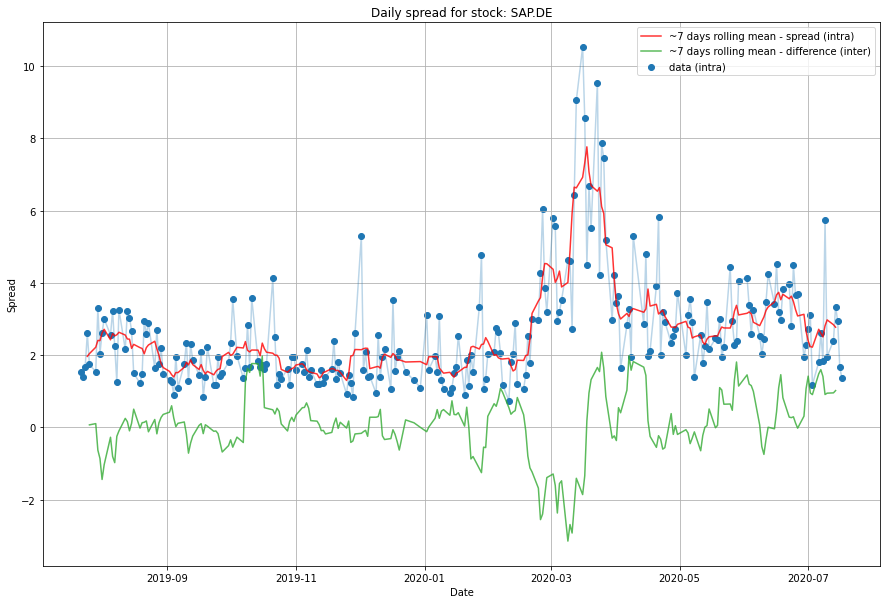

In [414]:
# target values from notebook "price_targets"

results, df = calc_metrics(TICKER, target=154.60, dtarget=0.894427)
results = pd.json_normalize(results)

In [415]:
results.head()

,ticker,kgv,delta_kgv,dividend_yield,delta_dividend_yield,crv,delta_crv,tsr,delta_tsr,peg,delta_peg,kuv,delta_kuv,spread_diff_corr
0,SAP.DE,50.29241,13.060055,0.011626,0.165525,2.752025,5.27154,0.149227,10.971531,10.058482,261.394692,6.061812,0.522687,28.347236
